In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout



In [14]:
data_folder = 'data/'
df = pd.read_csv(data_folder+'NGC2403.curve.02', skiprows=0, sep=' ')
N = len(df.values)
df.head()

,r,vrotvdisp,verr,vapp,vrec,err,Unnamed: 6,pa,incl,vsys
0,4.0,1.98,5.33,1.60,12.87,-4.82,6.926,125.8,61.5,132.8
1,8.0,15.78,6.32,1.16,25.77,8.24,7.691,125.9,61.5,132.8
2,12.0,22.30,4.10,0.62,26.63,18.43,4.584,125.9,61.5,132.8
3,16.0,32.16,3.90,0.50,37.04,27.73,4.542,125.9,61.5,132.8
4,20.0,39.67,4.06,0.46,43.24,36.12,4.433,125.9,61.5,132.8


In [39]:
df = df[['r', 'vrotvdisp', 'verr']]
df.head()

,r,vrotvdisp,verr
0,4.0,1.98,5.33
1,8.0,15.78,6.32
2,12.0,22.30,4.10
3,16.0,32.16,3.90
4,20.0,39.67,4.06


In [43]:
np.min(df['r'].values), np.max(df['r'].values)

(4.0, 1152.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


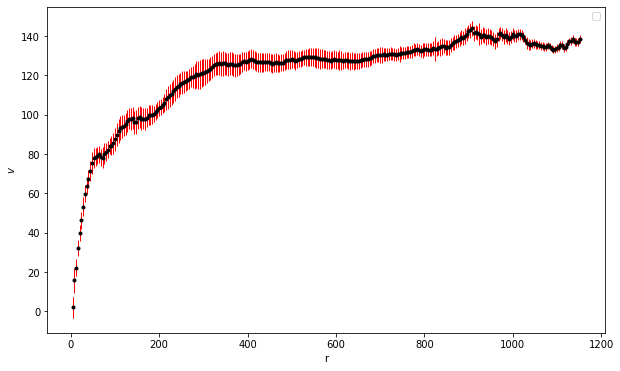

In [26]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(df['r'].values, df['vrotvdisp'].values, yerr=df['verr'].values, fmt='.', color='k', elinewidth=1, ecolor='red')
plt.ylabel("$v$")
plt.xlabel("r")
plt.legend()

In [27]:
randomize = np.random.permutation(N)
data = df.values[randomize]

z = data[:,0]
y = data[:,1:]

In [28]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [29]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [30]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((230, 1), (230, 1), (58, 1), (58, 1))

In [31]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0005)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 150])
model.summary()


2023-03-26 21:02:49.040334: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-26 21:02:49.040377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: isidro-PC
2023-03-26 21:02:49.040390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: isidro-PC
2023-03-26 21:02:49.040545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.85.5
2023-03-26 21:02:49.040583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.85.5
2023-03-26 21:02:49.040594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.85.5
2023-03-26 21:02:49.041659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAP

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 MCDropout_1 (MCDropout)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               30150     
                                                                 
 MCDropout_3 (MCDropout)     (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 3

In [32]:
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=1000,verbose=1,
                                    validation_data=(z_test, y_test))



Epoch 1/1000
58/58 [==============================] - 1s 3ms/step - loss: 6871.6045 - val_loss: 4320.8511
Epoch 2/1000
58/58 [==============================] - 0s 1ms/step - loss: 1680.0085 - val_loss: 719.0367
Epoch 3/1000
58/58 [==============================] - 0s 1ms/step - loss: 760.9784 - val_loss: 404.4203
Epoch 4/1000
58/58 [==============================] - 0s 1ms/step - loss: 604.2768 - val_loss: 335.6716
Epoch 5/1000
58/58 [==============================] - 0s 1ms/step - loss: 487.6280 - val_loss: 204.8804
Epoch 6/1000
58/58 [==============================] - 0s 1ms/step - loss: 351.8973 - val_loss: 223.7521
Epoch 7/1000
58/58 [==============================] - 0s 1ms/step - loss: 311.8204 - val_loss: 276.1323
Epoch 8/1000
58/58 [==============================] - 0s 1ms/step - loss: 292.0396 - val_loss: 284.1606
Epoch 9/1000
58/58 [==============================] - 0s 1ms/step - loss: 259.5115 - val_loss: 164.0359
Epoch 10/1000
58/58 [==============================] - 0s 1ms

58/58 [==============================] - 0s 1ms/step - loss: 112.3147 - val_loss: 94.3721
Epoch 80/1000
58/58 [==============================] - 0s 1ms/step - loss: 90.7171 - val_loss: 81.3164
Epoch 81/1000
58/58 [==============================] - 0s 1ms/step - loss: 95.7591 - val_loss: 67.3462
Epoch 82/1000
58/58 [==============================] - 0s 1ms/step - loss: 93.4279 - val_loss: 78.7103
Epoch 83/1000
58/58 [==============================] - 0s 1ms/step - loss: 97.6748 - val_loss: 76.7923
Epoch 84/1000
58/58 [==============================] - 0s 1ms/step - loss: 93.5372 - val_loss: 75.2469
Epoch 85/1000
58/58 [==============================] - 0s 1ms/step - loss: 97.6358 - val_loss: 68.6183
Epoch 86/1000
58/58 [==============================] - 0s 1ms/step - loss: 109.9375 - val_loss: 82.3224
Epoch 87/1000
58/58 [==============================] - 0s 1ms/step - loss: 93.7381 - val_loss: 80.3262
Epoch 88/1000
58/58 [==============================] - 0s 1ms/step - loss: 108.2090 -

Epoch 158/1000
58/58 [==============================] - 0s 1ms/step - loss: 75.0376 - val_loss: 90.0570
Epoch 159/1000
58/58 [==============================] - 0s 1ms/step - loss: 118.3645 - val_loss: 70.9562
Epoch 160/1000
58/58 [==============================] - 0s 1ms/step - loss: 95.8264 - val_loss: 67.5386
Epoch 161/1000
58/58 [==============================] - 0s 1ms/step - loss: 81.2892 - val_loss: 85.2176
Epoch 162/1000
58/58 [==============================] - 0s 1ms/step - loss: 80.7706 - val_loss: 78.0775
Epoch 163/1000
58/58 [==============================] - 0s 1ms/step - loss: 96.2876 - val_loss: 58.4434
Epoch 164/1000
58/58 [==============================] - 0s 1ms/step - loss: 79.3021 - val_loss: 91.2301
Epoch 165/1000
58/58 [==============================] - 0s 1ms/step - loss: 89.6954 - val_loss: 65.0036
Epoch 166/1000
58/58 [==============================] - 0s 1ms/step - loss: 91.1520 - val_loss: 61.3994
Epoch 167/1000
58/58 [==============================] - 0s 1ms/

58/58 [==============================] - 0s 1ms/step - loss: 82.2481 - val_loss: 91.7989
Epoch 237/1000
58/58 [==============================] - 0s 1ms/step - loss: 92.6972 - val_loss: 65.1654
Epoch 238/1000
58/58 [==============================] - 0s 1ms/step - loss: 76.2850 - val_loss: 88.0654
Epoch 239/1000
58/58 [==============================] - 0s 2ms/step - loss: 89.7351 - val_loss: 80.6010
Epoch 240/1000
58/58 [==============================] - 0s 1ms/step - loss: 69.4357 - val_loss: 91.1498
Epoch 241/1000
58/58 [==============================] - 0s 1ms/step - loss: 82.3988 - val_loss: 62.1990
Epoch 242/1000
58/58 [==============================] - 0s 1ms/step - loss: 81.8425 - val_loss: 68.8367
Epoch 243/1000
58/58 [==============================] - 0s 1ms/step - loss: 61.5105 - val_loss: 65.5345
Epoch 244/1000
58/58 [==============================] - 0s 1ms/step - loss: 71.1863 - val_loss: 70.7932
Epoch 245/1000
58/58 [==============================] - 0s 1ms/step - loss: 92.

Epoch 315/1000
58/58 [==============================] - 0s 1ms/step - loss: 72.1771 - val_loss: 72.0741
Epoch 316/1000
58/58 [==============================] - 0s 1ms/step - loss: 69.1047 - val_loss: 62.6865
Epoch 317/1000
58/58 [==============================] - 0s 1ms/step - loss: 73.7679 - val_loss: 90.9137
Epoch 318/1000
58/58 [==============================] - 0s 1ms/step - loss: 79.2101 - val_loss: 52.9160
Epoch 319/1000
58/58 [==============================] - 0s 1ms/step - loss: 78.3796 - val_loss: 74.1236
Epoch 320/1000
58/58 [==============================] - 0s 1ms/step - loss: 76.9048 - val_loss: 69.6235
Epoch 321/1000
58/58 [==============================] - 0s 1ms/step - loss: 69.6825 - val_loss: 52.4701
Epoch 322/1000
58/58 [==============================] - 0s 1ms/step - loss: 64.9549 - val_loss: 63.6073
Epoch 323/1000
58/58 [==============================] - 0s 1ms/step - loss: 69.0873 - val_loss: 72.7029
Epoch 324/1000
58/58 [==============================] - 0s 1ms/s

Epoch 394/1000
58/58 [==============================] - 0s 1ms/step - loss: 54.9453 - val_loss: 65.4923
Epoch 395/1000
58/58 [==============================] - 0s 1ms/step - loss: 68.7579 - val_loss: 85.8878
Epoch 396/1000
58/58 [==============================] - 0s 1ms/step - loss: 67.4082 - val_loss: 50.9047
Epoch 397/1000
58/58 [==============================] - 0s 1ms/step - loss: 59.1736 - val_loss: 60.6100
Epoch 398/1000
58/58 [==============================] - 0s 1ms/step - loss: 57.9845 - val_loss: 60.7741
Epoch 399/1000
58/58 [==============================] - 0s 1ms/step - loss: 79.3027 - val_loss: 75.4113
Epoch 400/1000
58/58 [==============================] - 0s 1ms/step - loss: 83.2734 - val_loss: 59.4327
Epoch 401/1000
58/58 [==============================] - 0s 1ms/step - loss: 79.6990 - val_loss: 62.2904
Epoch 402/1000
58/58 [==============================] - 0s 1ms/step - loss: 83.4958 - val_loss: 62.8910
Epoch 403/1000
58/58 [==============================] - 0s 1ms/s

Epoch 473/1000
58/58 [==============================] - 0s 1ms/step - loss: 62.9167 - val_loss: 68.4369
Epoch 474/1000
58/58 [==============================] - 0s 1ms/step - loss: 50.3823 - val_loss: 64.5826
Epoch 475/1000
58/58 [==============================] - 0s 1ms/step - loss: 68.1391 - val_loss: 47.3420
Epoch 476/1000
58/58 [==============================] - 0s 1ms/step - loss: 69.8582 - val_loss: 71.4840
Epoch 477/1000
58/58 [==============================] - 0s 1ms/step - loss: 55.3018 - val_loss: 75.4368
Epoch 478/1000
58/58 [==============================] - 0s 1ms/step - loss: 58.4333 - val_loss: 39.5370
Epoch 479/1000
58/58 [==============================] - 0s 1ms/step - loss: 59.7229 - val_loss: 57.8087
Epoch 480/1000
58/58 [==============================] - 0s 1ms/step - loss: 63.8399 - val_loss: 55.5379
Epoch 481/1000
58/58 [==============================] - 0s 1ms/step - loss: 50.3642 - val_loss: 70.2907
Epoch 482/1000
58/58 [==============================] - 0s 1ms/s

Epoch 552/1000
58/58 [==============================] - 0s 1ms/step - loss: 56.9471 - val_loss: 56.8064
Epoch 553/1000
58/58 [==============================] - 0s 1ms/step - loss: 55.4548 - val_loss: 46.2177
Epoch 554/1000
58/58 [==============================] - 0s 1ms/step - loss: 58.3760 - val_loss: 62.9411
Epoch 555/1000
58/58 [==============================] - 0s 1ms/step - loss: 66.0121 - val_loss: 44.1474
Epoch 556/1000
58/58 [==============================] - 0s 1ms/step - loss: 68.1804 - val_loss: 68.5614
Epoch 557/1000
58/58 [==============================] - 0s 1ms/step - loss: 61.4957 - val_loss: 57.9672
Epoch 558/1000
58/58 [==============================] - 0s 1ms/step - loss: 62.4266 - val_loss: 45.5428
Epoch 559/1000
58/58 [==============================] - 0s 1ms/step - loss: 55.9428 - val_loss: 50.1623
Epoch 560/1000
58/58 [==============================] - 0s 1ms/step - loss: 70.0220 - val_loss: 65.6846
Epoch 561/1000
58/58 [==============================] - 0s 1ms/s

Epoch 631/1000
58/58 [==============================] - 0s 1ms/step - loss: 68.2967 - val_loss: 49.6473
Epoch 632/1000
58/58 [==============================] - 0s 1ms/step - loss: 62.6021 - val_loss: 50.3536
Epoch 633/1000
58/58 [==============================] - 0s 1ms/step - loss: 57.8911 - val_loss: 60.7571
Epoch 634/1000
58/58 [==============================] - 0s 1ms/step - loss: 63.0963 - val_loss: 48.8002
Epoch 635/1000
58/58 [==============================] - 0s 1ms/step - loss: 66.6170 - val_loss: 37.9810
Epoch 636/1000
58/58 [==============================] - 0s 1ms/step - loss: 63.1208 - val_loss: 75.5865
Epoch 637/1000
58/58 [==============================] - 0s 1ms/step - loss: 61.2335 - val_loss: 66.4443
Epoch 638/1000
58/58 [==============================] - 0s 1ms/step - loss: 55.4098 - val_loss: 47.0189
Epoch 639/1000
58/58 [==============================] - 0s 1ms/step - loss: 55.8600 - val_loss: 55.6071
Epoch 640/1000
58/58 [==============================] - 0s 1ms/s

Epoch 710/1000
58/58 [==============================] - 0s 1ms/step - loss: 58.9468 - val_loss: 34.4230
Epoch 711/1000
58/58 [==============================] - 0s 1ms/step - loss: 49.9976 - val_loss: 40.6880
Epoch 712/1000
58/58 [==============================] - 0s 1ms/step - loss: 66.7474 - val_loss: 46.2853
Epoch 713/1000
58/58 [==============================] - 0s 1ms/step - loss: 53.4624 - val_loss: 79.8718
Epoch 714/1000
58/58 [==============================] - 0s 2ms/step - loss: 59.3691 - val_loss: 31.3532
Epoch 715/1000
58/58 [==============================] - 0s 1ms/step - loss: 59.5585 - val_loss: 71.7584
Epoch 716/1000
58/58 [==============================] - 0s 1ms/step - loss: 59.1249 - val_loss: 52.1149
Epoch 717/1000
58/58 [==============================] - 0s 1ms/step - loss: 71.4529 - val_loss: 57.8028
Epoch 718/1000
58/58 [==============================] - 0s 1ms/step - loss: 60.4932 - val_loss: 68.0016
Epoch 719/1000
58/58 [==============================] - 0s 1ms/s

Epoch 789/1000
58/58 [==============================] - 0s 1ms/step - loss: 52.0345 - val_loss: 42.2040
Epoch 790/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.3111 - val_loss: 42.4618
Epoch 791/1000
58/58 [==============================] - 0s 1ms/step - loss: 51.9297 - val_loss: 50.8163
Epoch 792/1000
58/58 [==============================] - 0s 1ms/step - loss: 66.6739 - val_loss: 66.1518
Epoch 793/1000
58/58 [==============================] - 0s 1ms/step - loss: 55.2178 - val_loss: 64.7176
Epoch 794/1000
58/58 [==============================] - 0s 1ms/step - loss: 60.0062 - val_loss: 50.2781
Epoch 795/1000
58/58 [==============================] - 0s 1ms/step - loss: 52.3287 - val_loss: 52.3018
Epoch 796/1000
58/58 [==============================] - 0s 1ms/step - loss: 54.8859 - val_loss: 44.9586
Epoch 797/1000
58/58 [==============================] - 0s 1ms/step - loss: 55.6505 - val_loss: 42.2235
Epoch 798/1000
58/58 [==============================] - 0s 1ms/s

Epoch 868/1000
58/58 [==============================] - 0s 1ms/step - loss: 61.3233 - val_loss: 57.3449
Epoch 869/1000
58/58 [==============================] - 0s 1ms/step - loss: 48.6336 - val_loss: 46.5645
Epoch 870/1000
58/58 [==============================] - 0s 1ms/step - loss: 44.5960 - val_loss: 52.1031
Epoch 871/1000
58/58 [==============================] - 0s 1ms/step - loss: 53.7927 - val_loss: 68.9453
Epoch 872/1000
58/58 [==============================] - 0s 1ms/step - loss: 56.4184 - val_loss: 46.1854
Epoch 873/1000
58/58 [==============================] - 0s 1ms/step - loss: 58.7993 - val_loss: 46.6838
Epoch 874/1000
58/58 [==============================] - 0s 1ms/step - loss: 57.3808 - val_loss: 46.6720
Epoch 875/1000
58/58 [==============================] - 0s 1ms/step - loss: 55.5618 - val_loss: 38.2646
Epoch 876/1000
58/58 [==============================] - 0s 1ms/step - loss: 62.2628 - val_loss: 43.5742
Epoch 877/1000
58/58 [==============================] - 0s 1ms/s

Epoch 947/1000
58/58 [==============================] - 0s 1ms/step - loss: 52.1377 - val_loss: 48.3492
Epoch 948/1000
58/58 [==============================] - 0s 1ms/step - loss: 56.4247 - val_loss: 57.3333
Epoch 949/1000
58/58 [==============================] - 0s 1ms/step - loss: 55.6314 - val_loss: 61.5129
Epoch 950/1000
58/58 [==============================] - 0s 1ms/step - loss: 67.5964 - val_loss: 41.7197
Epoch 951/1000
58/58 [==============================] - 0s 1ms/step - loss: 52.7170 - val_loss: 59.9814
Epoch 952/1000
58/58 [==============================] - 0s 1ms/step - loss: 49.9690 - val_loss: 62.6425
Epoch 953/1000
58/58 [==============================] - 0s 1ms/step - loss: 57.4767 - val_loss: 47.7261
Epoch 954/1000
58/58 [==============================] - 0s 1ms/step - loss: 61.0718 - val_loss: 46.1096
Epoch 955/1000
58/58 [==============================] - 0s 1ms/step - loss: 68.8188 - val_loss: 44.5978
Epoch 956/1000
58/58 [==============================] - 0s 1ms/s

In [33]:
model_train.history['val_loss'][-1]

57.58123016357422

In [51]:


# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(3, 1150, test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



32/32 [==============================] - 0s 758us/step


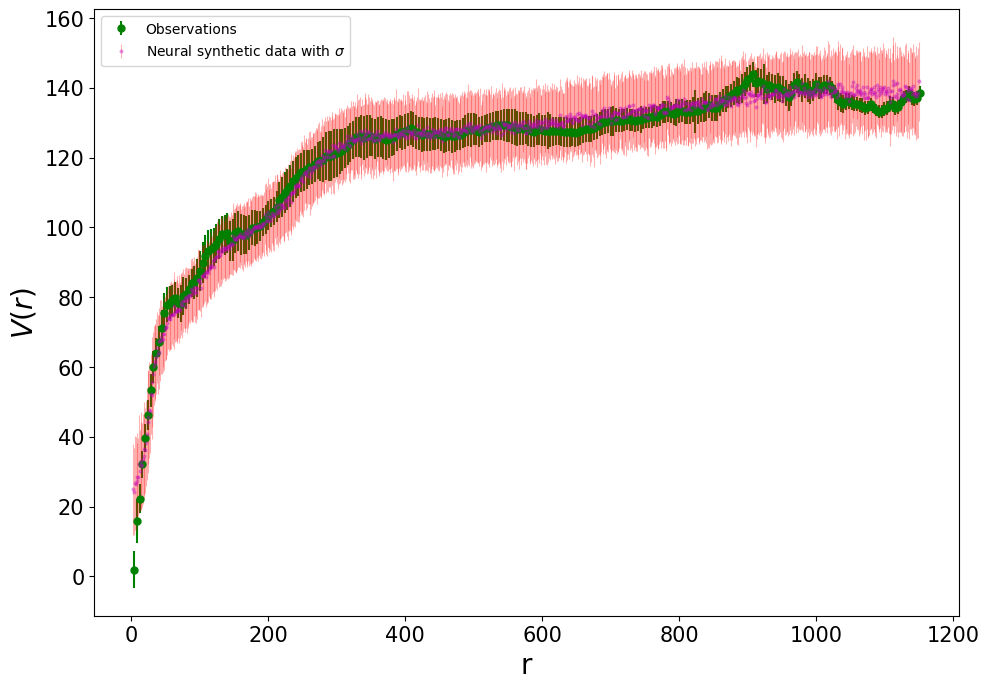

In [54]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['r'].values, df['vrotvdisp'].values, yerr=df['verr'].values, fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Neural synthetic data with $\sigma$')


# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$V(r)$", fontsize=20)
plt.xlabel("r", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("neural_reconstruction_RC.png", dpi=100)

(0.0, 100.0)

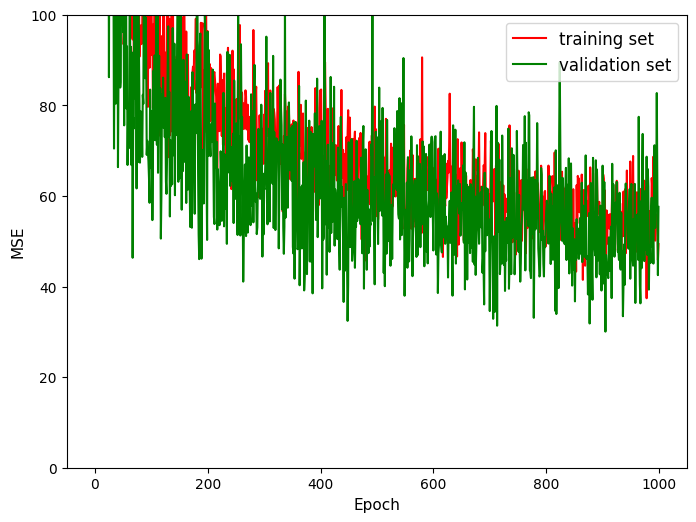

In [53]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 100)